In [1]:
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the labeled dataset
data_path = '../../data/btc_usd_h4_labeled.csv'
df = pd.read_csv(data_path, index_col='timestamp', parse_dates=True)

# Drop any remaining NaN values just in case
df.dropna(inplace=True)

print("Labeled data loaded successfully.")
print(f"Data shape: {df.shape}")

Labeled data loaded successfully.
Data shape: (16581, 31)


In [2]:
# Define our features (X) - these are all the indicator columns
# We exclude the basic OHLCV and the target itself
features = [col for col in df.columns if col not in ['open', 'high', 'low', 'close', 'volume', 'target']]
X = df[features]

# Define our target (y)
y = df['target']

# Split the data into training and testing sets
# IMPORTANT: For time-series data, we should not shuffle!
# We train on the past and test on the most recent future.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data split into training and testing sets.
X_train shape: (13264, 25)
X_test shape: (3317, 25)


In [3]:
# --- COMPLETE REPLACEMENT FOR CELL 3 ---

import pandas as pd
import xgboost as xgb

# Define our features (X) and target (y)
features = [col for col in df.columns if col not in ['open', 'high', 'low', 'close', 'volume', 'target']]
X = df[features]
y = df['target']

# Split the data chronologically
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Data split into training and testing sets.")

# --- Calculate class weights to handle imbalance ---
class_counts = y_train.value_counts()
# Calculate weight for the '0' (HOLD) class
# This makes each 'HOLD' sample as important as all 'BUY' and 'SELL' samples combined
weight_for_hold = (class_counts.get(1, 0) + class_counts.get(-1, 0)) / class_counts.get(0, 1)
print(f"Calculated weight for HOLD class: {weight_for_hold:.2f}")

# Create a weight array for each sample in the training set
sample_weights = y_train.apply(lambda x: weight_for_hold if x == 0 else 1)

# Initialize the XGBoost Classifier with stronger regularization
model = xgb.XGBClassifier(
    # --- Core Parameters (these stay the same) ---
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    gamma=5,
    reg_lambda=10,
    subsample=0.7,
    colsample_bytree=0.9
)

# Map target labels for the model
y_train_mapped = y_train.replace({-1: 2})
y_test_mapped = y_test.replace({-1: 2})

# Train the model using the sample weights
print("Training the XGBoost model with sample weights...")
model.fit(X_train, y_train_mapped, sample_weight=sample_weights.values)
print("Model training complete.")

Data split into training and testing sets.
Calculated weight for HOLD class: 1.33
Training the XGBoost model with sample weights...


/Users/aliefchandrawijaya/trading_bot/venv/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model training complete.


Classification Report:
              precision    recall  f1-score   support

          -1       0.37      0.35      0.36       954
           0       0.44      0.74      0.55      1309
           1       0.71      0.13      0.22      1054

    accuracy                           0.44      3317
   macro avg       0.51      0.41      0.38      3317
weighted avg       0.51      0.44      0.39      3317


Confusion Matrix:


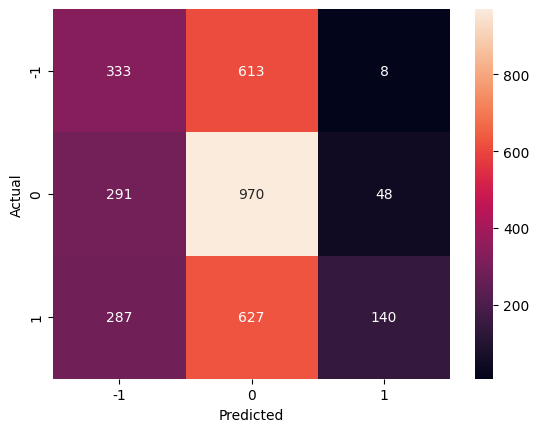

In [4]:
# Make predictions on the test data
y_pred_mapped = model.predict(X_test)

# Map the predictions back from 2 to -1 to make the report readable
y_pred = pd.Series(y_pred_mapped).replace({2: -1}).values

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Display the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [5]:
# Save the trained model to the 'models' directory
model_path = '../../models/btc_usd_h4.pkl'
joblib.dump(model, model_path)

print(f"Model saved successfully to: {model_path}")

Model saved successfully to: ../../models/btc_usd_h4.pkl
